In [19]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [20]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../dataset/ERIC.csv')
df1=df.reset_index()['Close']

In [21]:
df1.describe()

count    3369.000000
mean        9.737061
std         2.346864
min         4.850000
25%         7.920000
50%         9.760000
75%        11.770000
max        15.380000
Name: Close, dtype: float64

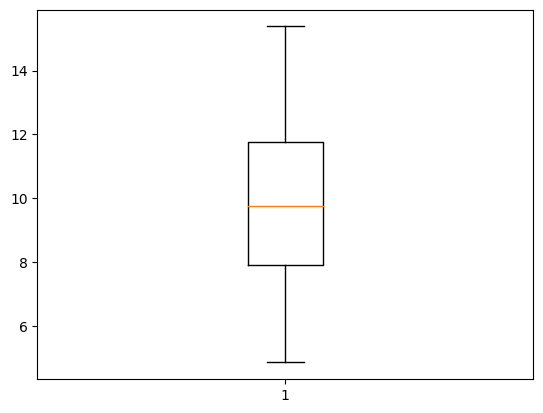

In [22]:
# Creating plot
plt.boxplot(df1)
 
# show plot
plt.show()

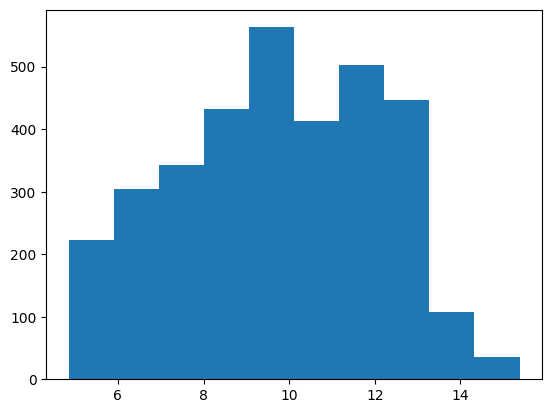

In [23]:
# Creating Histogram
plt.hist(df1)
 
# show Histogram
plt.show()

In [24]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [25]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [26]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [27]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [28]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [29]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
30/30 [==============================] - 2s 23ms/step - loss: 0.0209 - val_loss: 0.0013
Epoch 2/100
30/30 [==============================] - 0s 16ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 9.2680e-04 - val_loss: 9.0284e-04
Epoch 4/100
30/30 [==============================] - 0s 16ms/step - loss: 8.3745e-04 - val_loss: 8.2928e-04
Epoch 5/100
30/30 [==============================] - 0s 15ms/step - loss: 7.8561e-04 - val_loss: 7.9315e-04
Epoch 6/100
30/30 [==============================] - 0s 15ms/step - loss: 7.4859e-04 - val_loss: 7.2243e-04
Epoch 7/100
30/30 [==============================] - 0s 15ms/step - loss: 7.2125e-04 - val_loss: 6.8178e-04
Epoch 8/100
30/30 [==============================] - 0s 15ms/step - loss: 6.9255e-04 - val_loss: 6.4662e-04
Epoch 9/100
30/30 [==============================] - 0s 16ms/step - loss: 6.6989e-04 - val_loss: 6.3809e-04
Epoch 10/100
30/30 [========================

In [31]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

18/18 [==============================] - 0s 5ms/step


In [32]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [33]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 9.30399589960529
Testing RMSE: 8.57823058977604


In [34]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=614
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.64672365 0.65147198 0.67901235 0.671415   0.68471035 0.66951567
 0.65242165 0.65811966 0.65337132 0.65622032 0.65716999 0.67426401
 0.66381766 0.67426401 0.68281102 0.6980057  0.69325736 0.67901235
 0.68471035 0.665717   0.66381766 0.65432099 0.64957265 0.65622032
 0.65337132 0.66381766 0.65716999 0.662868   0.7008547  0.68186135
 0.75498575 0.64387464 0.72364672 0.75023742 0.75308642 0.79012346
 0.79202279 0.78822412 0.80531814 0.82336182 0.8300095  0.8300095
 0.8357075  0.80911681 0.78632479 0.77872745 0.75973409 0.74643875
 0.73694207 0.73219373 0.74169041 0.72934473 0.75403609 0.75023742
 0.72269706 0.68660969 0.69135802 0.68566002 0.72364672 0.7331434
 0.81481481 0.81956315 0.83855651 0.84805318 0.84045584 0.81101614
 0.80531814 0.81006648 0.81861349 0.79107312 0.79392213 0.82336182
 0.80911681 0.8005698  0.79202279 0.78062678 0.81196581 0.82336182
 0.83190883 0.86419753 0.86704653 0.84995252 0.86704653 0.83855651
 0.85375119 0.87369421 0.84425451 0.82526116 0.90123

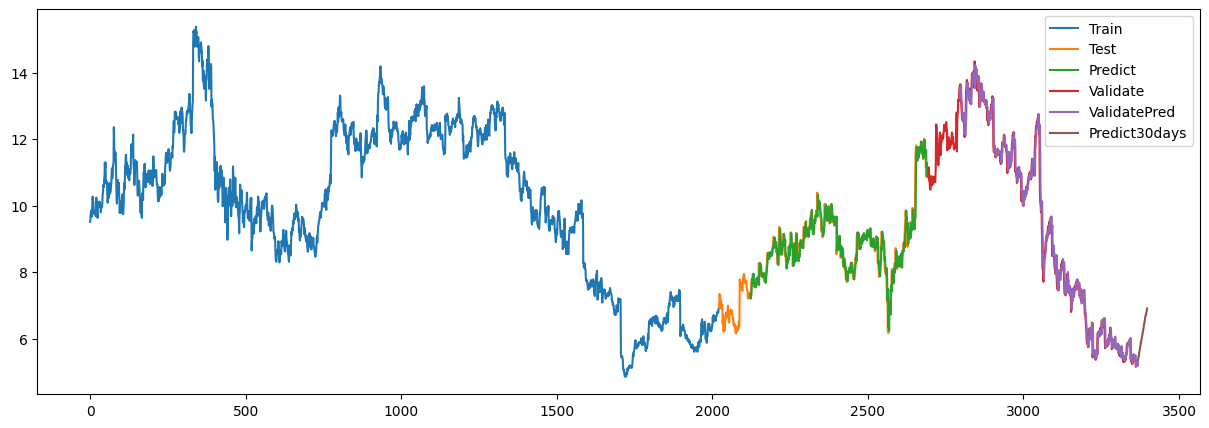

In [37]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.subplots(figsize=(15, 5))
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [36]:
scaler.inverse_transform(lst_output)

array([[5.36342468],
       [5.4158235 ],
       [5.4339959 ],
       [5.5102512 ],
       [5.58762086],
       [5.61978804],
       [5.67914955],
       [5.74946041],
       [5.78779404],
       [5.88501688],
       [5.88822764],
       [5.96826249],
       [5.99154656],
       [6.05355387],
       [6.10810783],
       [6.17050522],
       [6.20264886],
       [6.27814636],
       [6.30932862],
       [6.4106209 ],
       [6.43585034],
       [6.50750199],
       [6.54157562],
       [6.62058381],
       [6.68323766],
       [6.70334825],
       [6.69982501],
       [6.78810088],
       [6.81805485],
       [6.90429264]])